C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


Starting augmentation comparison...
Loading embeddings and molecule data...
Loaded 9937 molecules
Recreating PyG dataset...
Successfully recreated 9937 PyG data objects
Recreating model...
Loading model checkpoint from ./checkpoints/gan_cl_checkpoint_50.pt...
Selecting random molecules for comparison...
Comparing augmentation methods...


C:\Users\Malli\AppData\Local\Temp\ipykernel_25524\2548266799.py:1077: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=tor

Successfully rebuilt 500/500 original molecules
Successfully rebuilt 500/500 GAN-augmented molecules
Successfully rebuilt 500/500 traditional-augmented molecules
Creating visualizations...


C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Comparison complete! Results saved to ./augmentation_comparison
Comparing augmentation methods...
Successfully rebuilt 500/500 original molecules
Successfully rebuilt 500/500 GAN-augmented molecules
Successfully rebuilt 500/500 traditional-augmented molecules
Creating visualizations...


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


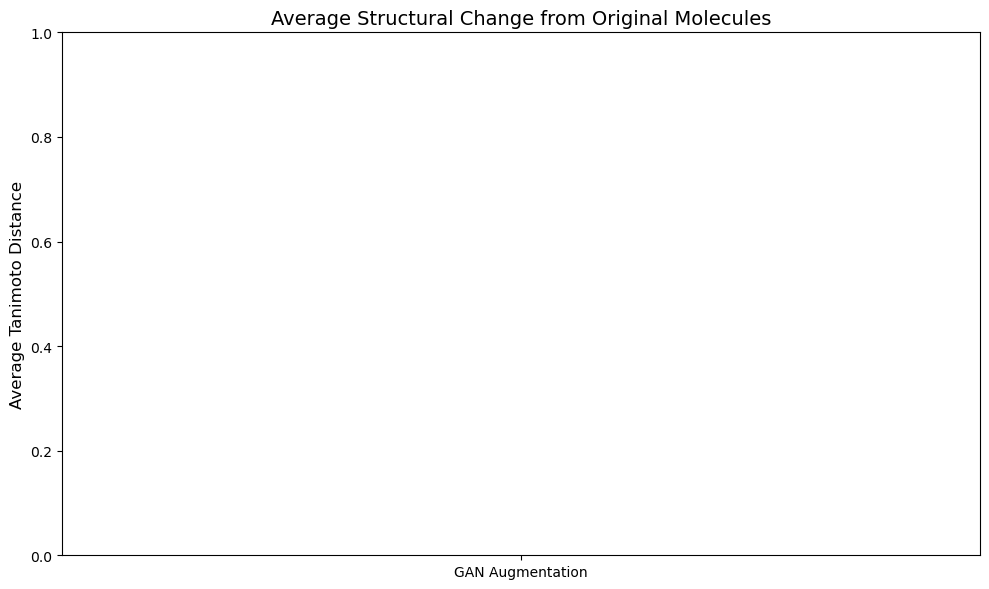

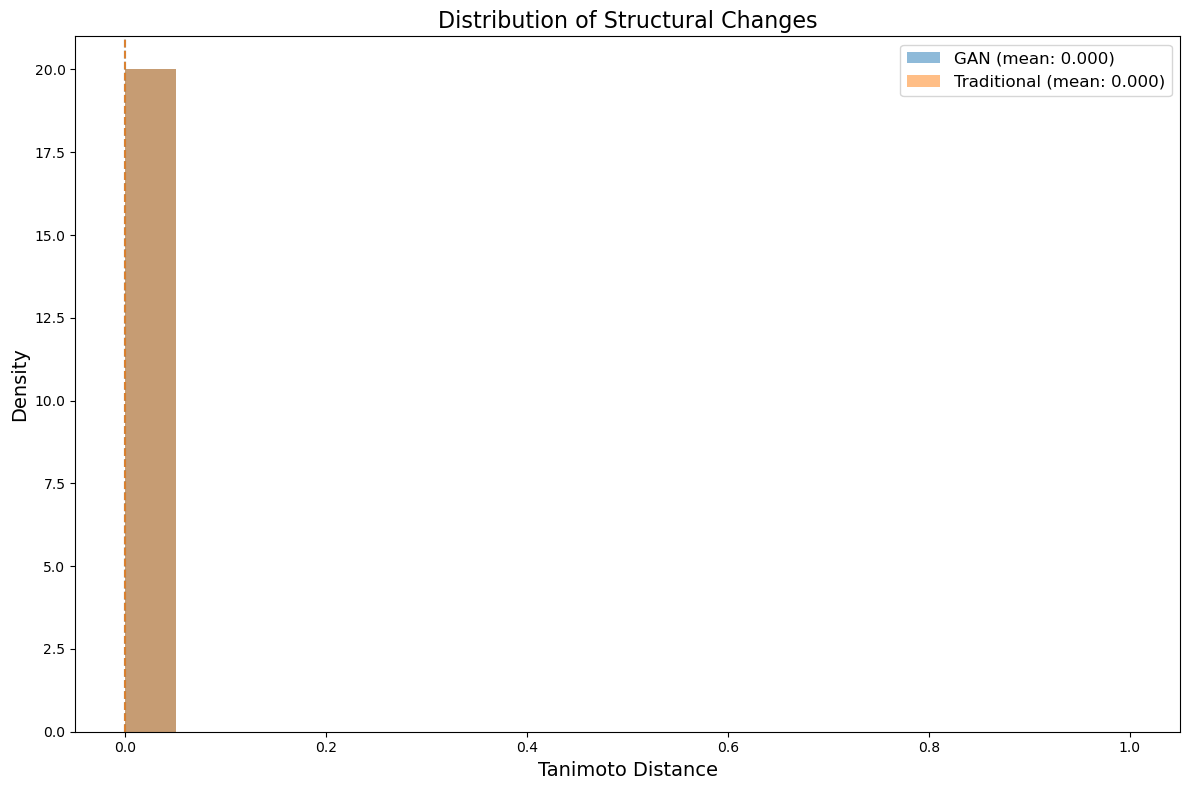

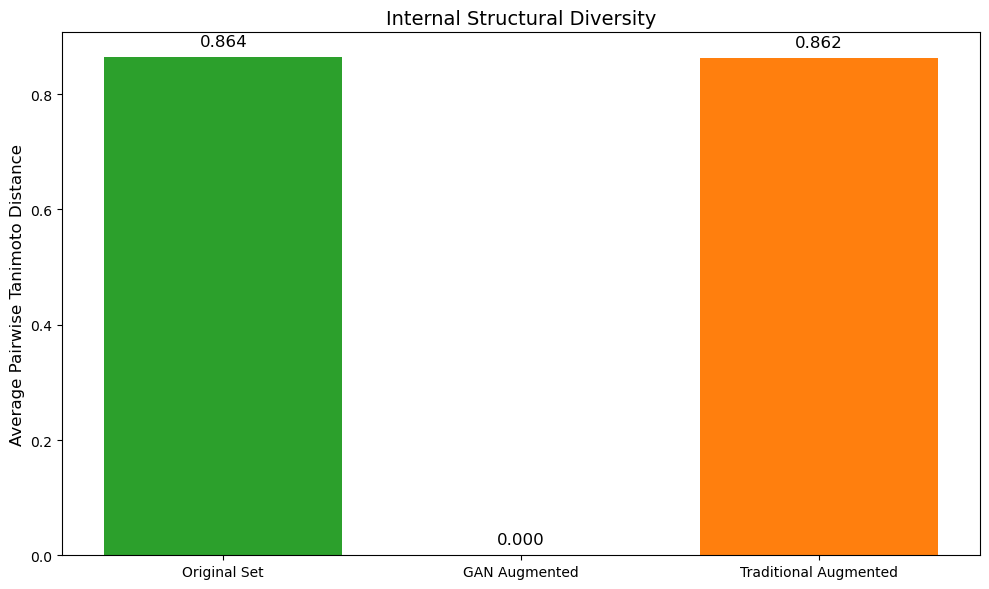

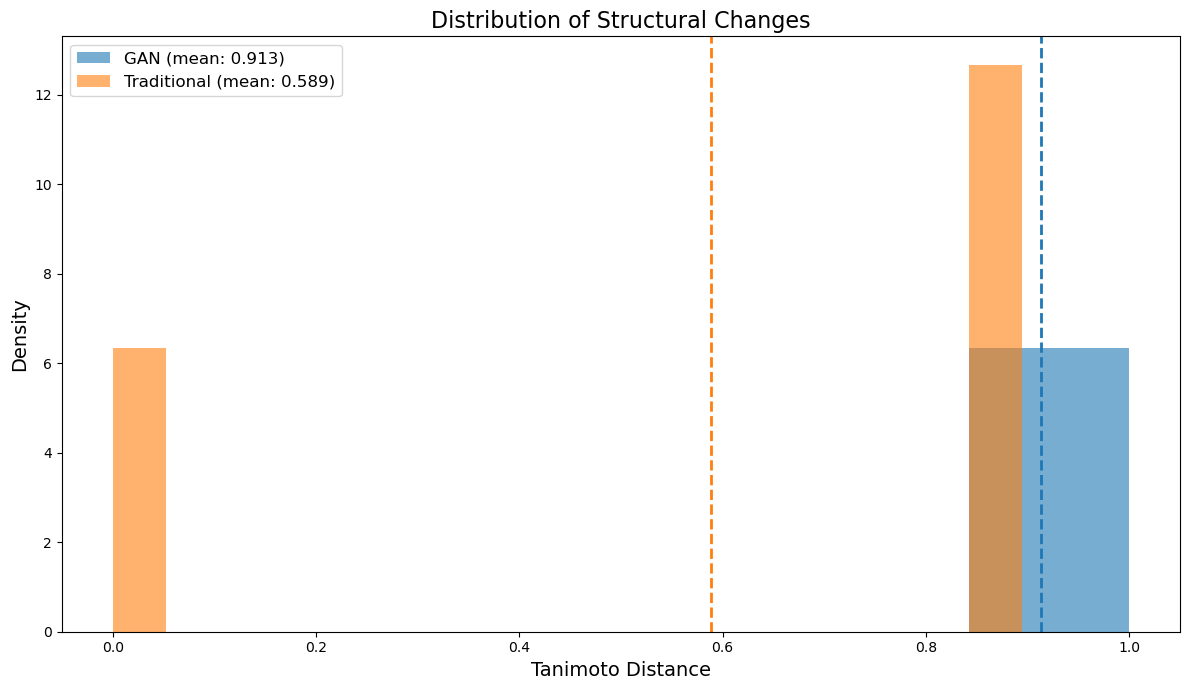

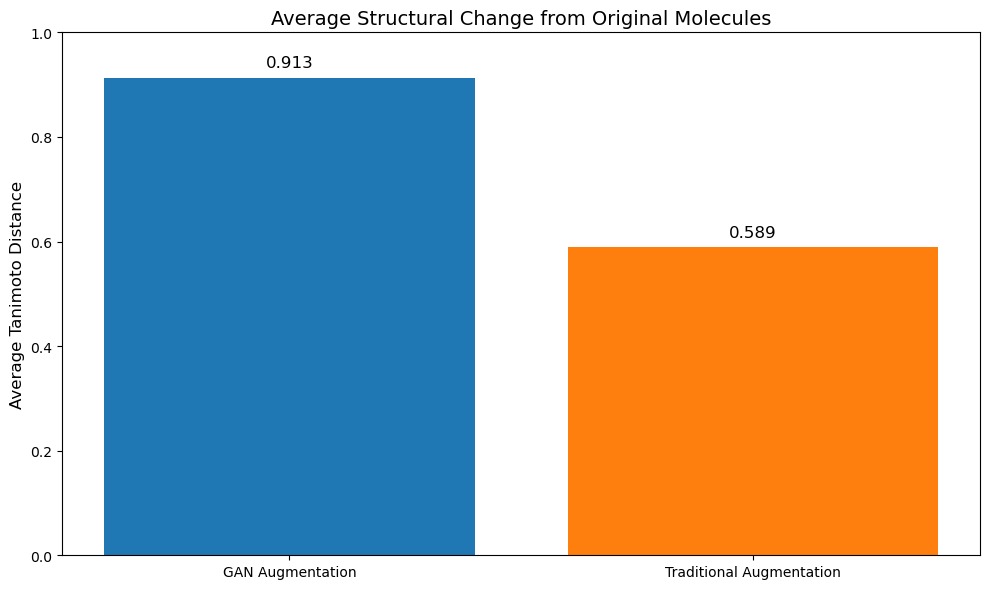

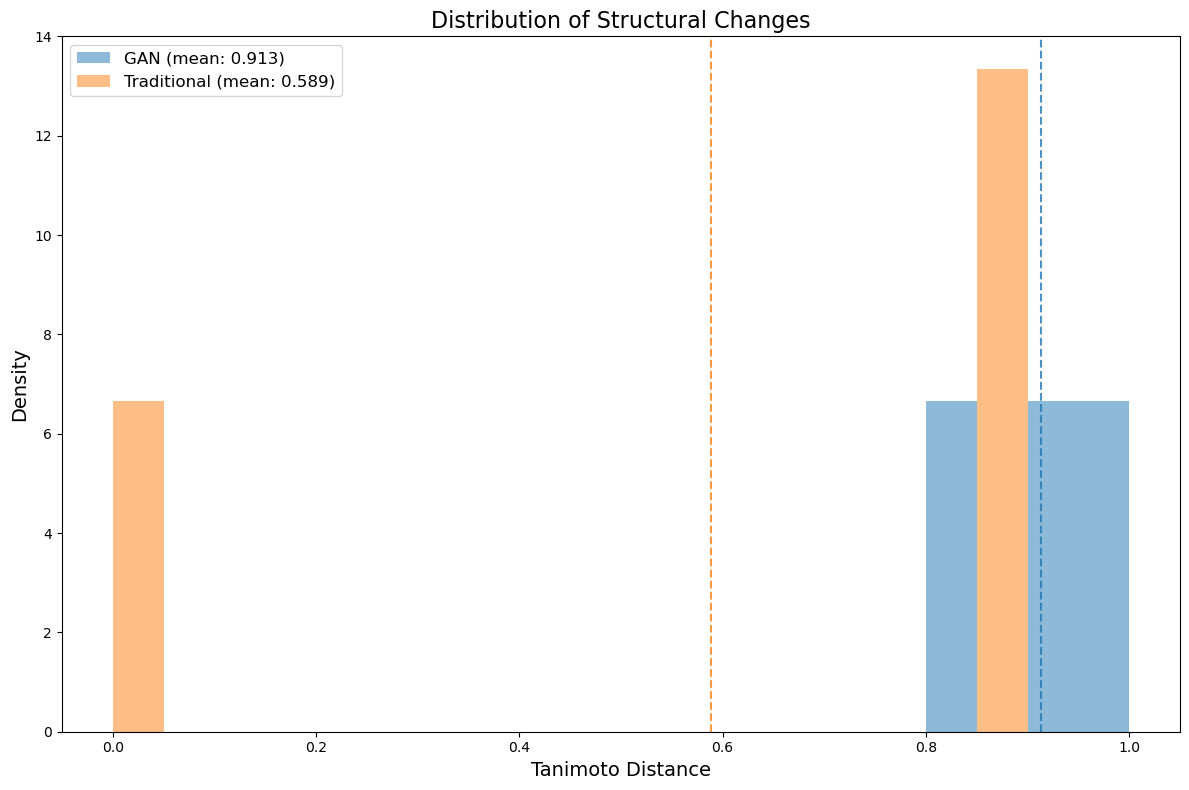

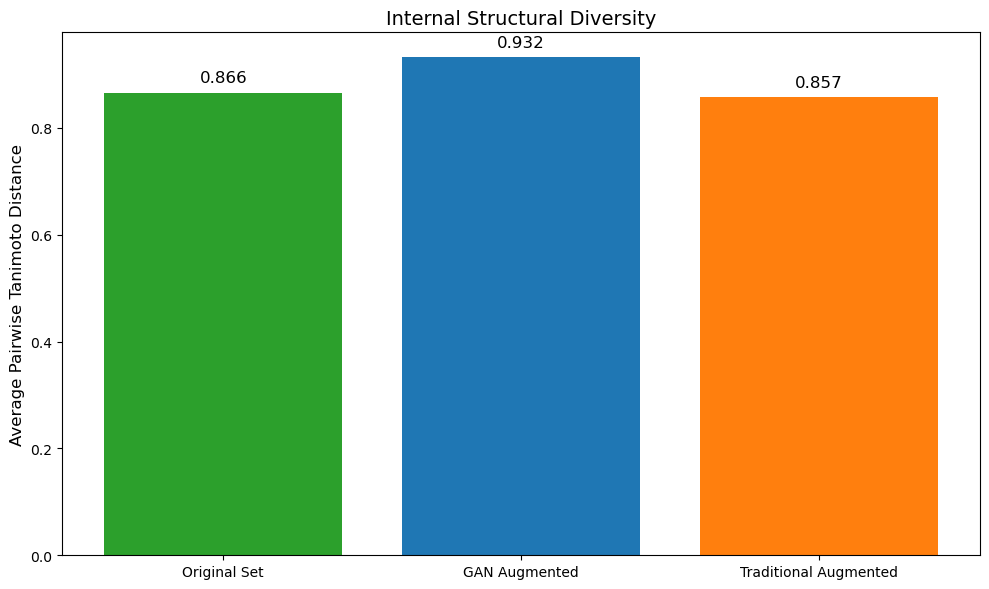

In [1]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from torch_geometric.data import Data
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit import RDLogger
from collections import defaultdict

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data  # Add this import
from typing import Tuple, List, Optional
import copy
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
import os
# Add the current directory to the path
# sys.path.append(os.path.dirname(os.path.abspath(__file__)))

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

def get_model_config(dataset):
    """Get model configuration based on dataset features"""
    if dataset is None or len(dataset) == 0:
        print("Error: Empty dataset provided to get_model_config")
        return None
        
    sample_data = dataset[0]
#     print(f"Sample data attributes: {dir(sample_data)}")
#     print(f"Has x_cat: {hasattr(sample_data, 'x_cat')}, shape: {sample_data.x_cat.shape if hasattr(sample_data, 'x_cat') else 'N/A'}")
#     print(f"Has x_phys: {hasattr(sample_data, 'x_phys')}, shape: {sample_data.x_phys.shape if hasattr(sample_data, 'x_phys') else 'N/A'}")
#     print(f"Has edge_attr: {hasattr(sample_data, 'edge_attr')}, shape: {sample_data.edge_attr.shape if hasattr(sample_data, 'edge_attr') else 'N/A'}")
    
    # Calculate input dimensions
    try:
        node_dim = sample_data.x_cat.shape[1] + sample_data.x_phys.shape[1]
        edge_dim = sample_data.edge_attr.shape[1]
        
        config = GanClConfig(
            node_dim=node_dim,
            edge_dim=edge_dim,
            hidden_dim=128,
            output_dim=128,
            queue_size=65536,
            momentum=0.999,
            temperature=0.07,
            decay=0.99999,
            dropout_ratio=0.25
        )
        
        return config
    except Exception as e:
        print(f"Error creating config: {e}")
        return None
    
@dataclass
class GanClConfig:
    """Configuration for GAN-CL training"""
    node_dim: int
    edge_dim: int
    hidden_dim: int = 128
    output_dim: int = 128
    queue_size: int = 65536
    momentum: float = 0.999
    temperature: float = 0.07
    decay: float = 0.99999
    dropout_ratio: float = 0.25

# config = GanClConfig(
#     node_dim=node_dim,
#     edge_dim=edge_dim,
#     hidden_dim=128,
#     output_dim=128,
#     queue_size=65536,
#     momentum=0.999,
#     temperature=0.07,
#     decay=0.99999,
#     dropout_ratio=0.25
# )

#     return config

class MemoryQueue:
    """Memory queue with temporal decay for contrastive learning"""
    def __init__(self, size: int, dim: int, decay: float = 0.99999):
        self.size = size
        self.dim = dim
        self.decay = decay
        self.ptr = 0
        self.full = False
        
        # Initialize queue
        self.queue = nn.Parameter(F.normalize(torch.randn(size, dim), dim=1), requires_grad=False)
        self.queue_age = nn.Parameter(torch.zeros(size), requires_grad=False)
        self.queue = F.normalize(self.queue, dim=1)
        
    def update_queue(self, keys: torch.Tensor):
        """Update queue with new keys"""
        batch_size = keys.shape[0]
        
        # Increment age of all entries
        self.queue_age += 1
        
        # Add new keys
        if self.ptr + batch_size <= self.size:
            self.queue[self.ptr:self.ptr + batch_size] = keys
            self.queue_age[self.ptr:self.ptr + batch_size] = 0
        else:
            # Handle overflow
            rem = self.size - self.ptr
            self.queue[self.ptr:] = keys[:rem]
            self.queue[:batch_size-rem] = keys[rem:]
            self.queue_age[self.ptr:] = 0
            self.queue_age[:batch_size-rem] = 0
            self.full = True
            
        self.ptr = (self.ptr + batch_size) % self.size
        
    def get_decay_weights(self) -> torch.Tensor:
        """Get temporal decay weights for queue entries"""
        return self.decay ** self.queue_age
        
    def compute_contrastive_loss(self, query: torch.Tensor, positive_key: torch.Tensor, 
                                temperature: float = 0.07) -> torch.Tensor:
        """Compute contrastive loss with temporal decay"""
        # Normalize embeddings
        query = F.normalize(query, dim=1)
        positive_key = F.normalize(positive_key, dim=1)
        queue = F.normalize(self.queue, dim=1)
        
        # Compute logits
        l_pos = torch.einsum('nc,nc->n', [query, positive_key]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [query, queue.T])
        
        # Apply temporal decay to negative samples
        decay_weights = self.get_decay_weights()
        l_neg = l_neg * decay_weights.unsqueeze(0)
        
        # Temperature scaling
        logits = torch.cat([l_pos, l_neg], dim=1) / temperature
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=query.device)
        
        return F.cross_entropy(logits, labels)

class GraphGenerator(nn.Module):
    """Generator network with proper feature handling"""
    def __init__(self, node_dim: int, edge_dim: int, hidden_dim: int = 128):
        super().__init__()
        
        # Node feature processing
        self.node_encoder = nn.Sequential(
            nn.Linear(node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Edge feature processing
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Graph convolution layers
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        
        # Importance prediction layers
        self.node_importance = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
        self.edge_importance = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def normalize_features(self, x_cat, x_phys):
        """Normalize categorical and physical features separately"""
        # Convert categorical features to one-hot
        x_cat = x_cat.float()
        
        # Normalize physical features
        x_phys = x_phys.float()
        if x_phys.size(0) > 1:  # Only normalize if we have more than one sample
            x_phys = (x_phys - x_phys.mean(0)) / (x_phys.std(0) + 1e-5)
            
        return x_cat, x_phys
        
    def forward(self, data) -> Tuple[torch.Tensor, torch.Tensor]:
        # Normalize features
        x_cat, x_phys = self.normalize_features(data.x_cat, data.x_phys)
        
        # Concatenate features
        x = torch.cat([x_cat, x_phys], dim=-1)
        
        edge_index = data.edge_index
        edge_attr = data.edge_attr.float()  # Ensure float type
        
        # Initial feature encoding
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
        # Graph convolutions
        x = F.relu(self.conv1(x, edge_index))  # Removed edge_attr from GCNConv
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        
        # Predict importance scores
        node_scores = self.node_importance(x)
        
        # Edge scores using both connected nodes
        edge_features = torch.cat([
            x[edge_index[0]], 
            x[edge_index[1]]
        ], dim=-1)
        edge_scores = self.edge_importance(edge_features)
        
        return node_scores, edge_scores

class GraphDiscriminator(nn.Module):
    """Discriminator/Encoder network"""
    def __init__(self, node_dim: int, edge_dim: int, hidden_dim: int = 128, output_dim: int = 128):
        super().__init__()
        
        # Feature encoding
        self.node_encoder = nn.Sequential(
            nn.Linear(node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Graph convolution layers
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        
        # Projection head for contrastive learning
        self.projection = nn.Sequential(
            nn.Linear(output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def normalize_features(self, x_cat, x_phys):
        """Normalize categorical and physical features separately"""
        # Convert categorical features to one-hot
        x_cat = x_cat.float()
        
        # Normalize physical features
        x_phys = x_phys.float()
        if x_phys.size(0) > 1:  # Only normalize if we have more than one sample
            x_phys = (x_phys - x_phys.mean(0)) / (x_phys.std(0) + 1e-5)
            
        return x_cat, x_phys 
        
    def forward(self, data):
        # Normalize features
        x_cat, x_phys = self.normalize_features(data.x_cat, data.x_phys)
        
        # Concatenate features
        x = torch.cat([x_cat, x_phys], dim=-1)
        
        edge_index = data.edge_index
        edge_attr = data.edge_attr.float()  # Ensure float type
        batch = data.batch if hasattr(data, 'batch') else None
        
        # Initial feature encoding
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
        # Graph convolutions
        x = F.relu(self.conv1(x, edge_index))  # Removed edge_attr from GCNConv
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        
        # Global pooling
        if batch is not None:
            x = global_mean_pool(x, batch)
        else:
            # If no batch information, treat as single graph
            x = torch.mean(x, dim=0, keepdim=True)
        
        # Projection
        x = self.projection(x)
        
        return x

class MolecularGANCL(nn.Module):
    """Combined GAN and Contrastive Learning framework"""
    def __init__(self, config: GanClConfig):
        super().__init__()
        self.config = config
        
        # Add weight initialization
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        
        # Initialize networks
        self.generator = GraphGenerator(
            config.node_dim, 
            config.edge_dim, 
            config.hidden_dim * 2
        )
        
        self.encoder = GraphDiscriminator(
            config.node_dim,
            config.edge_dim,
            config.hidden_dim,
            config.output_dim
        )
        self.encoder.apply(init_weights)
        
        # Modified loss weights
        self.contrastive_weight = 1.0
        self.adversarial_weight = 0.1
        self.similarity_weight = 0.01
        
        # Temperature annealing
        self.initial_temperature = 0.1
        self.min_temperature = 0.05        
        
        # Create momentum encoder
        self.momentum_encoder = copy.deepcopy(self.encoder)
        for param in self.momentum_encoder.parameters():
            param.requires_grad = False
            
        # Initialize memory queue
        self.memory_queue = MemoryQueue(
            config.queue_size,
            config.output_dim,
            config.decay
        )
        
    @torch.no_grad()
    def _momentum_update(self):
        """Update momentum encoder"""
        for param_q, param_k in zip(self.encoder.parameters(), 
                                  self.momentum_encoder.parameters()):
            param_k.data = self.config.momentum * param_k.data + \
                          (1 - self.config.momentum) * param_q.data
                          
    def drop_graph_elements(self, data, node_scores: torch.Tensor, 
                          edge_scores: torch.Tensor):
        """Apply dropout to graph based on importance scores"""
        # Use random sampling with importance scores as probabilities
        node_mask = (torch.rand_like(node_scores) > self.config.dropout_ratio).float()
        edge_mask = (torch.rand_like(edge_scores) > self.config.dropout_ratio).float()

        # Apply masks
        x_cat_new = data.x_cat * node_mask
        x_phys_new = data.x_phys * node_mask
        edge_attr_new = data.edge_attr * edge_mask

        # Create new graph data object
        return Data(
            x_cat=x_cat_new,
            x_phys=x_phys_new,
            edge_index=data.edge_index,
            edge_attr=edge_attr_new,
            batch=data.batch if hasattr(data, 'batch') else None,
            num_nodes=data.num_nodes if hasattr(data, 'num_nodes') else None
        )
        
    def get_temperature(self, epoch, total_epochs):
        """Anneal temperature during training"""
        progress = epoch / total_epochs
        return max(self.initial_temperature * (1 - progress), self.min_temperature)
    
    def forward(self, data, epoch=0, total_epochs=50):
        # Get current temperature
        temperature = self.get_temperature(epoch, total_epochs)
        
        # Get importance scores from generator
        node_scores, edge_scores = self.generator(data)
        
        # Create perturbed graph
        perturbed_data = self.drop_graph_elements(data, node_scores, edge_scores)
        
        # Get embeddings
        query_emb = self.encoder(perturbed_data)
        with torch.no_grad():
            key_emb = self.momentum_encoder(data)
            original_emb = self.encoder(data).detach()
        
        # Compute losses with modified weights
        contrastive_loss = self.memory_queue.compute_contrastive_loss(
            query_emb, key_emb, temperature
        ) * self.contrastive_weight
        
        adversarial_loss = -F.mse_loss(query_emb, original_emb) * self.adversarial_weight
        similarity_loss = F.mse_loss(query_emb, original_emb) * self.similarity_weight
        
        return contrastive_loss, adversarial_loss, similarity_loss
    
    def get_embeddings(self, data) -> torch.Tensor:
        """Get embeddings for downstream tasks"""
        with torch.no_grad():
            return self.encoder(data)

def rebuild_molecule_from_graph_data(data):
    """Reconstruct RDKit molecule from PyG data"""
    # Maps for atom and bond features
    atom_list = list(range(1, 119))
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    try:
        # Create empty editable molecule
        mol = Chem.RWMol()
        
        # Add atoms based on x_cat data
        x_cat = data.x_cat
        if x_cat is None:
            return None
            
        for atom_features in x_cat:
            atomic_num = atom_list[int(atom_features[0])]
            atom = Chem.Atom(atomic_num)
            mol.AddAtom(atom)
        
        # Add bonds based on edge_index and edge_attr
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        
        if edge_index is None or edge_attr is None:
            return None
            
        # Process only in one direction (undirected edges appear twice)
        processed_edges = set()
        
        for i in range(edge_index.shape[1]):
            start, end = int(edge_index[0, i]), int(edge_index[1, i])
            if start >= mol.GetNumAtoms() or end >= mol.GetNumAtoms():
                continue
            if (start, end) in processed_edges or (end, start) in processed_edges:
                continue
                
            # Add the bond
            try:
                bond_type_idx = int(edge_attr[i][0])
                if bond_type_idx < len(bond_list):
                    bond_type = bond_list[bond_type_idx]
                    mol.AddBond(start, end, bond_type)
                    processed_edges.add((start, end))
            except Exception:
                continue
        
        # Convert to molecule
        try:
            final_mol = Chem.Mol(mol)
            for atom in final_mol.GetAtoms():
                atom.UpdatePropertyCache(strict=False)
            
            # Try to sanitize with error catching
            try:
                Chem.SanitizeMol(final_mol)
            except:
                pass
                
            return final_mol
        except Exception:
            return None
            
    except Exception:
        return None

def create_traditional_augmentations(data_list, methods=['random_drop', 'subgraph', 'edge_perturbation']):
    """Create traditional augmentations using multiple methods"""
    augmented_samples = []
    
    for data in data_list:
        augmented_data = None
        
        # Choose a random augmentation method
        method = np.random.choice(methods)
        
        if method == 'random_drop':
            # Random node and edge dropout
            dropout_ratio = 0.25
            
            # Create masks
            node_mask = torch.rand(data.x_cat.size(0)) > dropout_ratio
            edge_mask = torch.rand(data.edge_attr.size(0)) > dropout_ratio
            
            # Apply masks
            x_cat_new = data.x_cat.clone()
            x_phys_new = data.x_phys.clone()
            edge_attr_new = data.edge_attr.clone()
            
            # Mask nodes
            for i in range(len(node_mask)):
                if not node_mask[i]:
                    x_cat_new[i] = torch.zeros_like(x_cat_new[i])
                    x_phys_new[i] = torch.zeros_like(x_phys_new[i])
            
            # Mask edges
            for i in range(len(edge_mask)):
                if not edge_mask[i]:
                    edge_attr_new[i] = torch.zeros_like(edge_attr_new[i])
            
            # Create new graph
            augmented_data = Data(
                x_cat=x_cat_new,
                x_phys=x_phys_new,
                edge_index=data.edge_index,
                edge_attr=edge_attr_new,
                num_nodes=data.num_nodes
            )
                        
        elif method == 'subgraph':
            # Take a random subgraph
            graph_ratio = 0.8  # Keep 80% of nodes
            
            # Select random subset of nodes
            num_nodes = data.x_cat.size(0)
            num_keep = max(2, int(num_nodes * graph_ratio))  # Keep at least 2 nodes
            
            # Random selection without replacement
            keep_indices = torch.tensor(np.random.choice(
                num_nodes, num_keep, replace=False
            ))
            
            # Create node masks
            node_mask = torch.zeros(num_nodes, dtype=torch.bool)
            node_mask[keep_indices] = True
            
            # Apply node mask
            x_cat_new = data.x_cat[node_mask]
            x_phys_new = data.x_phys[node_mask]
            
            # Create mapping from old indices to new indices
            old_to_new = {int(old_idx): new_idx for new_idx, old_idx in enumerate(keep_indices)}
            
            # Filter edges
            edge_indices = []
            edge_attrs = []
            
            for i in range(data.edge_index.size(1)):
                src, dst = int(data.edge_index[0, i]), int(data.edge_index[1, i])
                
                if src in old_to_new and dst in old_to_new:
                    # Remap indices
                    new_src = old_to_new[src]
                    new_dst = old_to_new[dst]
                    
                    edge_indices.append([new_src, new_dst])
                    edge_attrs.append(data.edge_attr[i])
            
            # Convert to tensors
            if edge_indices:
                edge_index_new = torch.tensor(edge_indices).t()
                edge_attr_new = torch.stack(edge_attrs)
                
                # Create new graph
                augmented_data = Data(
                    x_cat=x_cat_new,
                    x_phys=x_phys_new,
                    edge_index=edge_index_new,
                    edge_attr=edge_attr_new,
                    num_nodes=num_keep
                )
            else:
                # If no edges, use random_drop instead
                augmented_data = create_traditional_augmentations([data], ['random_drop'])[0]
            
        elif method == 'edge_perturbation':
            # Randomly modify edge attributes
            perturb_ratio = 0.2  # Perturb 20% of edges
            
            # Create perturbed edge attributes
            edge_attr_new = data.edge_attr.clone()
            num_edges = edge_attr_new.size(0)
            
            # Select random subset to perturb
            perturb_indices = np.random.choice(
                num_edges, 
                int(num_edges * perturb_ratio), 
                replace=False
            )
            
            # Apply small perturbations
            for idx in perturb_indices:
                # Add small noise to edge attributes (except the first which is bond type)
                if edge_attr_new.size(1) > 1:
                    for j in range(1, edge_attr_new.size(1)):
                        # Fix: Create a scalar noise value
                        noise = torch.randn(1).item() * 0.1  # Get scalar value
                        edge_attr_new[idx, j] += noise
            
            # Create new graph
            augmented_data = Data(
                x_cat=data.x_cat.clone(),
                x_phys=data.x_phys.clone(),
                edge_index=data.edge_index.clone(),
                edge_attr=edge_attr_new,
                num_nodes=data.num_nodes
            )
        
        # Use the original if augmentation failed
        if augmented_data is None:
            augmented_data = data
            
        augmented_samples.append(augmented_data)
    
    return augmented_samples

def create_gan_augmentations(model, data_list):
    """Create augmentations using the trained GAN generator"""
    augmented_samples = []
    
    model.eval()
    with torch.no_grad():
        for data in data_list:
            try:
                # Convert data to GPU if model is on GPU
                device = next(model.parameters()).device
                data_device = data.to(device)
                
                # Get importance scores from generator
                node_scores, edge_scores = model.generator(data_device)
                
                # Create perturbed graph
                perturbed_data = model.drop_graph_elements(data_device, node_scores, edge_scores)
                
                # Move back to CPU
                augmented_samples.append(perturbed_data.cpu())
            except Exception as e:
                print(f"Error generating GAN augmentation: {e}")
                # Use the original if augmentation failed
                augmented_samples.append(data)
    
    return augmented_samples

def compare_diversity(model, samples):
    """Compare structural diversity between augmentation methods"""
    # Generate augmentations
    gan_samples = create_gan_augmentations(model, samples)
    traditional_samples = create_traditional_augmentations(samples)
    
    # Rebuild molecules
    original_mols = [rebuild_molecule_from_graph_data(data) for data in samples]
    gan_mols = [rebuild_molecule_from_graph_data(data) for data in gan_samples]
    traditional_mols = [rebuild_molecule_from_graph_data(data) for data in traditional_samples]
    
    # Filter out None molecules
    original_mols = [m for m in original_mols if m is not None]
    gan_mols = [m for m in gan_mols if m is not None]
    traditional_mols = [m for m in traditional_mols if m is not None]
    
    print(f"Successfully rebuilt {len(original_mols)}/{len(samples)} original molecules")
    print(f"Successfully rebuilt {len(gan_mols)}/{len(gan_samples)} GAN-augmented molecules")
    print(f"Successfully rebuilt {len(traditional_mols)}/{len(traditional_samples)} traditional-augmented molecules")
    
    # Calculate molecular fingerprints
    original_fps = []
    gan_fps = []
    traditional_fps = []
    
    for mol in original_mols:
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
            original_fps.append(fp)
        except:
            pass
            
    for mol in gan_mols:
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
            gan_fps.append(fp)
        except:
            pass
            
    for mol in traditional_mols:
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
            traditional_fps.append(fp)
        except:
            pass
    
    # Calculate pairwise Tanimoto distances
    gan_distances = []
    traditional_distances = []
    
    # Match molecules by index
    n = min(len(original_fps), len(gan_fps), len(traditional_fps))
    
    for i in range(n):
        # Calculate GAN similarity
        gan_sim = DataStructs.TanimotoSimilarity(original_fps[i], gan_fps[i])
        gan_distances.append(1.0 - gan_sim)  # Convert to distance
        
        # Calculate traditional similarity
        trad_sim = DataStructs.TanimotoSimilarity(original_fps[i], traditional_fps[i])
        traditional_distances.append(1.0 - trad_sim)  # Convert to distance
    
    # Calculate additional metrics
    def calculate_diversity(fps):
        n = len(fps)
        if n <= 1:
            return 0.0
            
        total = 0.0
        count = 0
        
        # Sample pairs to avoid O(n²) computation for large sets
        max_pairs = 10000
        if n * (n - 1) // 2 > max_pairs:
            # Random sampling of pairs
            pairs = 0
            while pairs < max_pairs:
                i = np.random.randint(0, n)
                j = np.random.randint(0, n)
                if i != j:
                    sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
                    total += (1.0 - sim)  # Convert to distance
                    count += 1
                    pairs += 1
        else:
            # All pairs
            for i in range(n):
                for j in range(i+1, n):
                    sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
                    total += (1.0 - sim)  # Convert to distance
                    count += 1
        
        return total / max(1, count)
    
    # Calculate internal diversity of each set
    original_diversity = calculate_diversity(original_fps)
    gan_diversity = calculate_diversity(gan_fps)
    traditional_diversity = calculate_diversity(traditional_fps)
    
    # Calculate property distributions
    def calculate_properties(mols):
        properties = {
            'MW': [],
            'LogP': [],
            'TPSA': [],
            'HBA': [],
            'HBD': [],
            'RotBonds': []
        }
        
        for mol in mols:
            try:
                properties['MW'].append(Chem.Descriptors.MolWt(mol))
                properties['LogP'].append(Chem.Descriptors.MolLogP(mol))
                properties['TPSA'].append(Chem.Descriptors.TPSA(mol))
                properties['HBA'].append(Chem.Descriptors.NumHAcceptors(mol))
                properties['HBD'].append(Chem.Descriptors.NumHDonors(mol))
                properties['RotBonds'].append(Chem.Descriptors.NumRotatableBonds(mol))
            except:
                pass
        
        return properties
    
    original_props = calculate_properties(original_mols)
    gan_props = calculate_properties(gan_mols)
    traditional_props = calculate_properties(traditional_mols)
    
    # Return comprehensive metrics
    return {
        'gan_avg_distance': np.mean(gan_distances),
        'traditional_avg_distance': np.mean(traditional_distances),
        'gan_distances': gan_distances,
        'traditional_distances': traditional_distances,
        'original_diversity': original_diversity,
        'gan_diversity': gan_diversity,
        'traditional_diversity': traditional_diversity,
        'original_properties': original_props,
        'gan_properties': gan_props,
        'traditional_properties': traditional_props
    }

def improved_tanimoto_histogram(gan_distances, traditional_distances, save_path=None):
    """
    Create a properly separated histogram of Tanimoto distances
    """
    # Handle empty or None values
    if not gan_distances or not traditional_distances:
        print("Warning: Empty distance data")
        return None
    
    # Filter out NaN values
    gan_arr = np.array([x for x in gan_distances if not np.isnan(x)])
    trad_arr = np.array([x for x in traditional_distances if not np.isnan(x)])
    
    plt.figure(figsize=(12, 7))
    
    # Create evenly spaced bins for better visualization
    bins = np.linspace(0, 1, 20)
    
    # Plot both histograms with transparency
    plt.hist(gan_arr, bins=bins, alpha=0.6, label=f'GAN (mean: {np.mean(gan_arr):.3f})', 
             color='#1f77b4', density=True)
    plt.hist(trad_arr, bins=bins, alpha=0.6, label=f'Traditional (mean: {np.mean(trad_arr):.3f})', 
             color='#ff7f0e', density=True)
    
    # Add mean lines with appropriate colors
    plt.axvline(x=np.mean(gan_arr), color='#1f77b4', linestyle='--', linewidth=2)
    plt.axvline(x=np.mean(trad_arr), color='#ff7f0e', linestyle='--', linewidth=2)
    
    plt.title('Distribution of Structural Changes', fontsize=16)
    plt.xlabel('Tanimoto Distance', fontsize=14)
    plt.ylabel('Density', fontsize=14)
#     plt.grid(alpha=0.3, linestyle='--')
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    return plt.gcf()

def plot_tanimoto_distribution(gan_distances, traditional_distances, save_path=None):
    """
    Create robust distribution plot for Tanimoto distances, handling edge cases
    
    Parameters:
    gan_distances (list): List of Tanimoto distances for GAN augmentations
    traditional_distances (list): List of Tanimoto distances for traditional augmentations
    save_path (str): Path to save the figure
    """
    # Handle empty lists or None values
    if gan_distances is None or len(gan_distances) == 0:
        print("Warning: GAN distances list is empty or None")
        gan_distances = [0]  # Default value for plotting
    
    if traditional_distances is None or len(traditional_distances) == 0:
        print("Warning: Traditional distances list is empty or None")
        traditional_distances = [0]  # Default value for plotting
    
    # Filter out NaN values
    gan_arr = np.array([x for x in gan_distances if not np.isnan(x)])
    trad_arr = np.array([x for x in traditional_distances if not np.isnan(x)])
    
    # Check if we have valid data after filtering
    if len(gan_arr) == 0 or len(trad_arr) == 0:
        print("Error: No valid data after filtering NaN values")
        # Create a simple error plot
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "Insufficient data for visualization", 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, fontsize=14)
        plt.title("Distribution of Structural Changes (Error)", fontsize=16)
        
        if save_path:
            plt.savefig(save_path, dpi=300)
        
        return plt.gcf()
    
    # Create a simple plot without seaborn for maximum compatibility
    plt.figure(figsize=(12, 8))
    
    # Plot histograms manually
    bins = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
    
    plt.hist(gan_arr, bins=bins, alpha=0.5, label=f'GAN (mean: {np.mean(gan_arr):.3f})', 
             color='#1f77b4', density=True)
    plt.hist(trad_arr, bins=bins, alpha=0.5, label=f'Traditional (mean: {np.mean(trad_arr):.3f})', 
             color='#ff7f0e', density=True)
    
    # Add mean lines
    plt.axvline(x=np.mean(gan_arr), color='#1f77b4', linestyle='--', alpha=0.8)
    plt.axvline(x=np.mean(trad_arr), color='#ff7f0e', linestyle='--', alpha=0.8)
    
    # Set titles and labels
    plt.title('Distribution of Structural Changes', fontsize=16)
    plt.xlabel('Tanimoto Distance', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    
    # Add grid
#     plt.grid(alpha=0.3, linestyle='--')
    
    # Improve legend
    plt.legend(fontsize=12)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

def plot_augmentation_comparison(diversity_data, save_dir=None):
    """Updated plot function incorporating the fixed distribution plot"""
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    all_figures = []
    
    # 1. Plot average Tanimoto distances (structural change)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    
    # Check if data exists
    if 'gan_avg_distance' in diversity_data and 'traditional_avg_distance' in diversity_data:
        methods = ['GAN Augmentation', 'Traditional Augmentation']
        avg_distances = [
            diversity_data.get('gan_avg_distance', 0),
            diversity_data.get('traditional_avg_distance', 0)
        ]
        
        ax1.bar(methods, avg_distances, color=['#1f77b4', '#ff7f0e'])
        ax1.set_ylabel('Average Tanimoto Distance', fontsize=12)
        ax1.set_title('Average Structural Change from Original Molecules', fontsize=14)
        ax1.set_ylim(0, 1.0)
        
        # Add values on top of bars
        for i, v in enumerate(avg_distances):
            ax1.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=12)
    else:
        ax1.text(0.5, 0.5, "Data not available", 
                ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, "augmentation_distance_comparison.png"), dpi=300)
    
    all_figures.append(fig1)
    
    # 2. Plot distribution of Tanimoto distances using robust function
    fig2 = plot_tanimoto_distribution(
        diversity_data.get('gan_distances', []),
        diversity_data.get('traditional_distances', []),
        save_path=os.path.join(save_dir, "augmentation_distance_distribution_fixed.png") if save_dir else None
    )
    
    all_figures.append(fig2)
    
    # 3. Plot internal diversity
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    
    if ('original_diversity' in diversity_data and 
        'gan_diversity' in diversity_data and 
        'traditional_diversity' in diversity_data):
        
        diversity_values = [
            diversity_data.get('original_diversity', 0),
            diversity_data.get('gan_diversity', 0),
            diversity_data.get('traditional_diversity', 0)
        ]
        diversity_labels = ['Original Set', 'GAN Augmented', 'Traditional Augmented']
        
        ax3.bar(diversity_labels, diversity_values, color=['#2ca02c', '#1f77b4', '#ff7f0e'])
        ax3.set_ylabel('Average Pairwise Tanimoto Distance', fontsize=12)
        ax3.set_title('Internal Structural Diversity', fontsize=14)
        
        # Add values on top of bars
        for i, v in enumerate(diversity_values):
            ax3.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=12)
    else:
        ax3.text(0.5, 0.5, "Data not available", 
                ha='center', va='center', transform=ax3.transAxes, fontsize=14)
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, "internal_diversity_comparison.png"), dpi=300)
    
    all_figures.append(fig3)
    
    # Save numerical results
    if save_dir:
        result_summary = {
            'GAN_avg_distance': diversity_data.get('gan_avg_distance', 'N/A'),
            'Traditional_avg_distance': diversity_data.get('traditional_avg_distance', 'N/A'),
            'Original_diversity': diversity_data.get('original_diversity', 'N/A'),
            'GAN_diversity': diversity_data.get('gan_diversity', 'N/A'),
            'Traditional_diversity': diversity_data.get('traditional_diversity', 'N/A'),
            'GAN_distances_count': len(diversity_data.get('gan_distances', [])),
            'Traditional_distances_count': len(diversity_data.get('traditional_distances', []))
        }
        
        with open(os.path.join(save_dir, 'numerical_results.txt'), 'w') as f:
            for key, value in result_summary.items():
                f.write(f"{key}: {value}\n")
    
    return all_figures

def compare_augmentation_methods():
    """Main function to compare augmentation methods"""
    print("Starting augmentation comparison...")
    
    # Load full model checkpoint
    checkpoint_path = './checkpoints/gan_cl_checkpoint_50.pt'  # Use your actual path
    
    # Load embeddings for reference
    embeddings_path = './embeddings/final_embeddings_molecules_20250309_110249.pkl'  # Update with your path
    
    # Check if files exist
    if not os.path.exists(checkpoint_path):
        print(f"Error: Checkpoint file not found at {checkpoint_path}")
        return None
        
    if not os.path.exists(embeddings_path):
        print(f"Error: Embeddings file not found at {embeddings_path}")
        return None
    
    # Load embeddings and dataset
    print("Loading embeddings and molecule data...")
    with open(embeddings_path, 'rb') as f:
        data = pickle.load(f)
    
    # Extract embeddings and molecule data
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    if molecule_data is None:
        print("Error: No molecule data found in embeddings file")
        return None
    
    print(f"Loaded {len(molecule_data)} molecules")
    
    # Recreate dataset from molecule data
    print("Recreating PyG dataset...")
    dataset = []
    for mol_data in molecule_data:
        try:
            data_obj = Data(
                x_cat=torch.tensor(mol_data['x_cat']),
                x_phys=torch.tensor(mol_data['x_phys']),
                edge_index=torch.tensor(mol_data['edge_index']),
                edge_attr=torch.tensor(mol_data['edge_attr']),
                num_nodes=mol_data['num_nodes']
            )
            dataset.append(data_obj)
        except Exception as e:
            print(f"Error converting molecule data: {e}")
    
    print(f"Successfully recreated {len(dataset)} PyG data objects")
    
    # Recreate model with same configuration
    print("Recreating model...")
    config = get_model_config(dataset)  
    model = MolecularGANCL(config)
    
    # Load saved state
    print(f"Loading model checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Choose random samples for comparison
    print("Selecting random molecules for comparison...")
    n_samples = 500
    indices = np.random.choice(len(dataset), min(n_samples, len(dataset)), replace=False)
    samples = [dataset[i] for i in indices]
    
    # Generate and compare augmentations
    print("Comparing augmentation methods...")
    comparison_results = compare_diversity(model, samples)
    
    # Create visualization
    print("Creating visualizations...")
    output_dir = './augmentation_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    plots = plot_augmentation_comparison(comparison_results, save_dir=output_dir)
    
    print(f"Comparison complete! Results saved to {output_dir}")
    
    # Save numerical results
    result_summary = {
        'GAN_avg_distance': comparison_results['gan_avg_distance'],
        'Traditional_avg_distance': comparison_results['traditional_avg_distance'],
        'Original_diversity': comparison_results['original_diversity'],
        'GAN_diversity': comparison_results['gan_diversity'],
        'Traditional_diversity': comparison_results['traditional_diversity']
    }
    
    with open(os.path.join(output_dir, 'numerical_results.txt'), 'w') as f:
        for key, value in result_summary.items():
            f.write(f"{key}: {value:.4f}\n")
            
            
    # Generate and compare augmentations
    print("Comparing augmentation methods...")
    comparison_results = compare_diversity(model, samples)
    
    # Create visualization
    print("Creating visualizations...")
    output_dir = './augmentation_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    # Create the improved histogram
    improved_tanimoto_histogram(
        comparison_results.get('gan_distances', []),
        comparison_results.get('traditional_distances', []),
        save_path=os.path.join(output_dir, "improved_tanimoto_distribution.png")
    )
    
    # Create other plots
    plots = plot_augmentation_comparison(comparison_results, save_dir=output_dir)            
    
    return comparison_results

if __name__ == "__main__":
    compare_augmentation_methods()